In [1]:
# %pip install torchviz

In [2]:
"""this is just for me since gpu bugged"""
# %env CUDA_VISIBLE_DEVICES=1

'this is just for me since gpu bugged'

In [8]:
# MAIN IMPORTS 
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm
from torchviz import make_dot
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim
import os
import torchvision.transforms as T
from skimage import transform as sktf
from skimage.util import random_noise
import random

# https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html - documetnation on how to make a pytorch model

# Data preprocessing 
- dataloaders
- augmentation pipeline
## Add notes on this here (what is happening)
- added some transforms that are vert and hor flips including rotation
- [ ] TODO Add random noise shapes in the image outside the mask maybe that will help the model learn better

In [9]:
#data loader
# the images are loaded as float32 and normalised
# the mask is thresholded at 0.5 
""" the permute is needed since the format for image tensors must be (C, H, W)
But when we read from opencv the shape is (H, W, C)
and the mask must be of dim (1, H, W) since single channel - unsqueeze add this channel
"""
# returned as tensors 

class PuzzleDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, num_transforms=0):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.num_transforms = num_transforms
        images = sorted(os.listdir(img_dir))
        masks = sorted(os.listdir(mask_dir))
        self.data = []

        for i in range(len(images)):
            img_path = os.path.join(self.img_dir, images[i])
            mask_path = os.path.join(self.mask_dir, masks[i])

          
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (512, 512))
            image = image.astype(np.float32)/255.0
            # image = Image.fromarray(image)  

            
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (512,512))
            mask = (mask > 0.5).astype(np.float32) 
            # mask = Image.fromarray(mask)  #   PIL image needed for transforms

            # store the original image and mask
            self.append_image_mask(image, mask)

            # do transformations 
            for _ in range(self.num_transforms):
                transformed_image, transformed_mask = self.apply_transform(image, mask)
                self.append_image_mask(transformed_image, transformed_mask)

    def apply_transform(self, image, mask):
        """Apply deterministic transformations to both image and mask
        This is imortant since using the torchvision.transforms was givin a random transform
        for both image and mask -> they didn't match up"""
        if self.transform:
            
            if random.random() > 0.5:
                image = np.fliplr(image)
                mask = np.fliplr(mask)

           
            if random.random() > 0.5:
                image = np.flipud(image)
                mask = np.flipud(mask)

            # Apply rotation deterministically
            angle = np.random.uniform(-30, 30)
            image = sktf.rotate(image, angle, mode="edge" , preserve_range=True)
            mask = sktf.rotate(mask, angle, mode="edge" , preserve_range=True)

        return image, mask

    def append_image_mask(self, image, mask):
        """need to store them as tensors."""
        image = torch.tensor(image.transpose((2, 0, 1)), dtype=torch.float32) # (C, H, W)
        mask = torch.tensor(mask[None, ...], dtype=torch.float32)   # (1, H, W)

       
        inverse_mask = 1 - mask
        combined_mask = torch.cat([inverse_mask, mask], dim=0)  # Combined (2, H, W)

     
        self.data.append((image, combined_mask))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


Loading the training dataset
- NOTE increasing batch size to 5 since our dataset size is up to 40 now

40
torch.Size([2, 512, 512])


(<Axes: >, <matplotlib.image.AxesImage at 0x7fd39c295f70>)

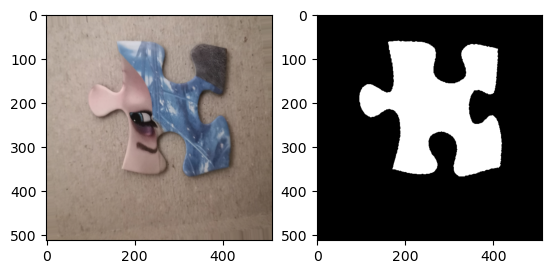

In [11]:
#  list of transformations
# transform_list = [
#     T.RandomHorizontalFlip(),
#     T.RandomVerticalFlip(),
#     T.RandomRotation(30),
# ]


train_dataset = PuzzleDataset(
    img_dir="./images-1024x768/train/",
    mask_dir="./masks-1024x768/train/", 
    transform=True,
    num_transforms=3  
)
#since 10 images batches of 1 should be fine can do like batches of 2 i guess                        
# note we now have more images since transform applied so maybe adjust batches
train_loader = DataLoader(train_dataset,batch_size =5, shuffle=True)

print(len(train_dataset.data))
# # to visualise the images + masks are in correct pairing
image, mask = train_dataset[6]

image_np = (image.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
mask_np = mask.permute(1, 2, 0).numpy()
print(mask.shape)


#to collapse the separate channels of bg and fg mask
if mask_np.shape[2] == 2:
    mask_np = np.argmax(mask_np, axis=2)
    
plt.figure()
plt.subplot(1,2,1), plt.imshow(image_np)
plt.subplot(1,2,2), plt.imshow(mask_np, cmap="gray")



# 3.1 Unet Construction
## Add notes on this here (what is happening)

In [12]:
""" Adding checkpoints as required and to avoid training everytime someone wants to test"""
def save_checkpoint(model, optimizer, epoch, filename="checkpoint.pth"):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved at epoch {epoch}.")


# use as in training
"""save_checkpoint(model, optimizer, epoch)"""


def load_checkpoint(model, optimizer, filename="checkpoint.pth"):
    if os.path.isfile(filename):
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        print(f"Checkpoint loaded from epoch {epoch}.")
        return epoch
    else:
        print("No checkpoint found.")
        return 0  # training from start ...

# before training starts to load model
"""start_epoch = load_checkpoint(model, optimizer)"""


'start_epoch = load_checkpoint(model, optimizer)'

## Vairant 1 : Using `torch.nn.ConvTranspose2d` for upsampling
- We removed the softmax in the unet with convolve to get to the required number of output classes (ask richard).
- Having the argmax inside the network caused issues with backprop so we only compute the raw logits and use these for the BCE loss
then use the apply softmax outside when performing inference on the test set.

In [23]:
# So this is the triple convolution, chat gpt says we should use normalization dont know if we should keep it
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.triple_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            # nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.triple_conv(x)
    
class Conv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Conv, self).__init__()
        self.triple_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            # nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.triple_conv(x)

    
# the down module is what the unet uses during the first half 
class Down(nn.Module):
    def __init__(self, in_channels,out_channels):
        super(Down, self).__init__()
        self.conv_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
            DoubleConv(in_channels,out_channels)
        )

    def forward(self, x):
        ret_ = self.conv_pool(x)
        return ret_

# up transpose, 
class UpConvTranspose(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConvTranspose, self).__init__()
        # to determine amount of out channels
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = Conv(out_channels, out_channels)

    def forward(self,x):
        x = self.up(x)
        # adding from the down section
        #x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UpBilinear(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBilinear, self).__init__()
        # the bilinear is provided by the nn module, we set the mode to bilinear here
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = Conv(out_channels, out_channels)

    def forward(self,x):
        x = self.up(x)
        return self.conv(x)
    
class Up(nn.Module):
    def __init__(self, in_channels, out_channels,mode):
        super(Up, self).__init__()
        if(mode=='convtranspose'):
            self.conv_pool = nn.Sequential(
                UpConvTranspose(in_channels,out_channels),
                Conv(out_channels,out_channels)
            )
        else:
            self.conv_pool = nn.Sequential(
                UpBilinear(in_channels,out_channels),
                Conv(out_channels,out_channels)
            )
        
        self.dconv = DoubleConv(out_channels*2,out_channels)
    
    def forward(self,x1,x2):
        x = self.conv_pool(x1)
        return self.dconv(torch.cat([x,x2],dim=1))

    
class SoftMax(nn.Module):
    def __init__(self, in_channels):
        super(SoftMax, self).__init__()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.softmax(x)
        return torch.argmax(x,dim=1)

class Unet(nn.Module):
    def __init__(self, n_channels, n_classes, variant='convtranspose'):
        super(Unet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.variant = variant

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64,128)
        self.down2 = Down(128,256)
        self.down3 = Down(256,512)
        self.down4 = Down(512,1024)
        
        self.up1 = Up(1024,512,variant)
        self.up2 = Up(512, 256,variant)
        self.up3 = Up(256, 128,variant)
        self.up4 = Up(128, 64,variant)

        self.outc = nn.Conv2d(64,2, kernel_size=1)


    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        logits = self.outc(x)
        
        return logits
    

In [14]:
def calculate_iou(preds, targets, threshold=0.5):
    preds = (torch.sigmoid(preds) > threshold).float()
    intersection = torch.sum(preds * targets, dim=[2, 3])
    union = torch.sum(preds, dim=[2, 3]) + torch.sum(targets, dim=[2, 3]) - intersection
    iou = (intersection + 1e-6) / (union + 1e-6)  # Add a small epsilon to avoid division by zero
    return iou.mean().item()


NOTE: I just pushed to the cpu when I try putting the model on the gpu I get weird errors in training 
that I used up all the GPU memory maybe you wont get this error then just comment out `device="cpu"
`

In [15]:
import wandb
print(wandb.__version__)


0.18.1


In [16]:

import wandb
wandb.init(project="Unet variant 1")


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: 2322203 (2322203-witwatersrand-university). Use `wandb login --relogin` to force relogin


In [17]:

val_dataset = PuzzleDataset(
    img_dir="./images-1024x768/val/",
    mask_dir="./masks-1024x768/val/", 
)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [ ]:

""" so I can train the model you can comment this block out"""

# torch.cuda.set_device(0)

In [ ]:

torch.cuda.empty_cache()

# I forced the device to cpu since I have no gpu comment that line out!
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

device = 'cpu'

# Model, criterion, and optimizer setup
model = Unet(n_channels=3, n_classes=2, variant='convtranspose')

# if torch.cuda.device_count() > 1:
#     print("Using", torch.cuda.device_count(), "GPUs!")
#     model = model.to('cuda:1')


model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

#  checkpoints if any
start_epoch = load_checkpoint(model, optimizer, filename="./checkpoints/var1/checkpoint.pth")

num_epochs = 1  
best_val_loss = float('inf')

for epoch in tqdm(range(start_epoch, num_epochs)):
    model.train()  
    running_loss = 0.0
    train_iou = 0.0
    
    for images, masks in tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        # outputs = outputs.float()
        # outputs = torch.softmax(outputs, dim=1)

        print(f"Outputs min: {outputs.min()}, max: {outputs.max()}, shape: {outputs.shape}")
        print(f"Masks min: {masks.min()}, max: {masks.max()}, shape: {masks.shape}")
        
        # BCE loss with logits 
        loss = criterion(outputs, masks)
        loss.backward()
        #gradient clipping I dunno why we get nans
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        optimizer.step()
        
        #  loss and IoU
        running_loss += loss.item()
        train_iou += calculate_iou(outputs, masks)

    train_loss = running_loss / len(train_loader)
    train_iou += train_iou/ len(train_loader)

    
    model.eval()
    val_loss = 0.0
    val_iou = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            val_iou += calculate_iou(outputs, masks)

    val_loss = val_loss / len(val_loader)
    val_iou += calculate_iou(torch.sigmoid(outputs), masks)


    #  training and validation metrics to wandb
    wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss, "train_iou": train_iou, "val_iou": val_iou})
    
    
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")
    
    # store model checkpoint if validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f"./checkpoints/var1/checkpoint_epoch_{epoch + 1}.pth")
        print(f"Checkpoint saved at epoch {epoch + 1}")

# close wandb run
wandb.finish()

# run tensorboard --logdir=runs to see networkls


Device: cuda
No checkpoint found.


  0%|          | 0/8 [00:00<?, ?it/s]

Outputs min: -1.7174041271209717, max: 1.7546900510787964, shape: torch.Size([5, 2, 512, 512])
Masks min: 0.0, max: 1.0, shape: torch.Size([5, 2, 512, 512])



 12%|█▎        | 1/8 [01:27<10:09, 87.01s/it]

Outputs min: nan, max: nan, shape: torch.Size([5, 2, 512, 512])
Masks min: 0.0, max: 1.0, shape: torch.Size([5, 2, 512, 512])


In [19]:
def display_tensor_as_image(tensor, channel_num, channel_index, height_index, width_index):
    # Move the tensor to CPU and convert it to a NumPy array
    tensor_np = tensor.cpu().numpy()
    if channel_index == 1:
        tensor_np = tensor_np.squeeze(0)

        channel_index -=1
        height_index-=1
        width_index-=1
        
    # Handle single-channel (grayscale) image
    if channel_num == 1:
        image_np = tensor_np.squeeze(channel_index)  # Remove the channel dimension
        plt.imshow(image_np, cmap="gray")
        plt.title("Single-channel image")
        plt.show()
    
    # Handle two-channel image (display channels separately)
    elif channel_num == 2:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Create 1 row, 2 columns
        for i in range(2):
            channel_image = tensor_np[i]  # Select each channel (e.g., 0 and 1)
            axes[i].imshow(channel_image, cmap="gray")
            axes[i].set_title(f"Channel {i}")
            print(f"Max value in channel {i}:", np.max(channel_image))
            print(f"Min value in channel {i}:", np.min(channel_image))
        plt.show()
    
    # Handle three-channel image (RGB)
    elif channel_num == 3:
        print(tensor_np.shape)
        # Transpose from (channels, height, width) to (height, width, channels)
        image_np = np.transpose(tensor_np, (height_index, width_index, channel_index))
        plt.imshow(image_np)
        plt.title("Three-channel image (RGB)")
        plt.show()


torch.Size([1, 3, 512, 512])
(3, 512, 512)


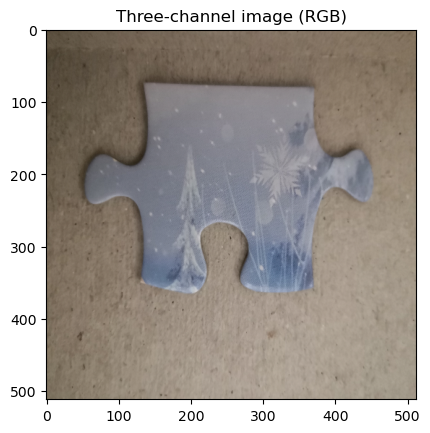

after softmax torch.Size([1, 2, 512, 512])
Max value in channel 0: nan
Min value in channel 0: nan
Max value in channel 1: nan
Min value in channel 1: nan


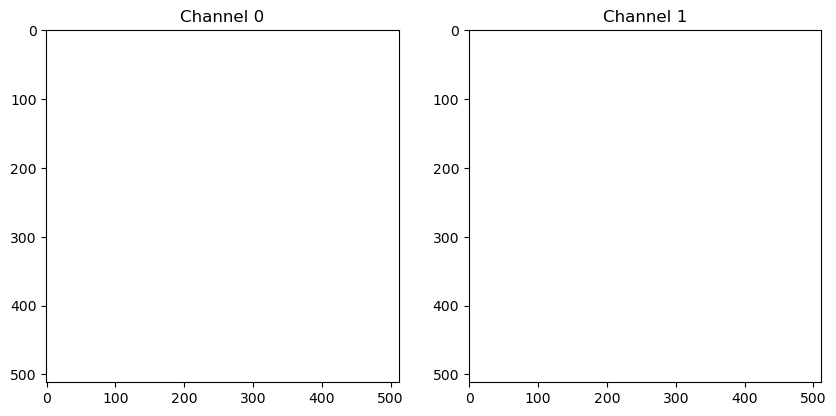

after argmax torch.Size([512, 512])
Max value in channel 0: 0
Min value in channel 0: 0


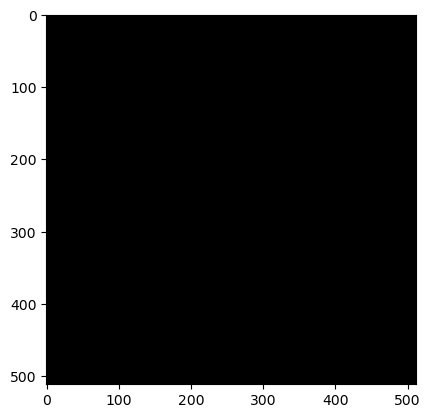

In [20]:
test_dataset = PuzzleDataset(img_dir = "./images-1024x768/test/",
                            mask_dir = "./masks-1024x768/test/")
#since 10 images batches of 1 should be fine can do like batches of 2 i guess                        
test_loader = DataLoader(test_dataset,batch_size =1, shuffle=True)
model.eval()
for image,mask in test_loader:
    images = image.to(device)
    print(images.shape)
    display_tensor_as_image(images,3,1,2,3)

    with torch.no_grad():
        outputs = model(images)
        #apply the softmax here not in the network
        probs = torch.softmax(outputs, dim = 1 )
        print("after softmax",probs.shape)

        # Swap Channel code
        # temp = probs[0][0].clone()
        # probs[0][0] = probs[0][1]
        # probs[0][1] = temp

        display_tensor_as_image(probs,2,1,2,3)
        probs = probs.squeeze(0)
        predicted_mask = torch.argmax(probs, dim=0)
        print("after argmax",predicted_mask.shape)
        image_np =  predicted_mask.cpu().numpy()
        print(f"Max value in channel {0}:", np.max(image_np))
        print(f"Min value in channel {0}:", np.min(image_np))
        plt.imshow(image_np ,vmin=0, vmax=1,cmap='gray')
        break
    # just for the push
    

## Vairant 2: Using `torch.nn.Upsample` for bilinear upsampling

# 3.2 Training and evaluation 
### Training
- [ ] Implement the training loop with binary cross entropy loss for pixel-wise classification
- [ ] Adam Optimiser to update the model parameters
**Note** have regularly saved checkpoints and evaluate model in the validation set to avoid over fitting

### Weights and biases integration
Log the following:
- [ ] Track BCE loss over epochs
- [ ] IoU for both training and validation sets to monitor the segmentation performance

### Need to submit from the wandb dashboard
- Loss curves (training and validation over epochs)
- IoU curves (training and validation over epochs)

### Remember to comment on comment on whether the model is overfitting and how to recognise this and deal with the problem

### Evaluation
evaluate model on test set 
- accuracy
- precision
- recall
- F1 score
- IoU

# Select the best model based on the validation IoU and report its performance on the test set

# 4 Other architectures
